# Milestone 2 - Phase 1

# Perkenalan

`Rio Armiga - FTDS012`

Dataset : Employee dataset

Objective : Membuat model classification menggunakan algioritma machine learning untuk memprediksi apakah seorang karyawan resign atau tidak.

# Import Library

In [61]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import  MinMaxScaler, OneHotEncoder, OrdinalEncoder, StandardScaler
from imblearn.over_sampling import SMOTENC
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import  classification_report, roc_auc_score, confusion_matrix, accuracy_score, recall_score
import pickle

# Data Loading

In [2]:
data = pd.read_csv('Employee.csv')
pd.set_option('display.max.columns', None)
data

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0
1,Bachelors,2013,Pune,1,28,Female,No,3,1
2,Bachelors,2014,New Delhi,3,38,Female,No,2,0
3,Masters,2016,Bangalore,3,27,Male,No,5,1
4,Masters,2017,Pune,3,24,Male,Yes,2,1
...,...,...,...,...,...,...,...,...,...
4648,Bachelors,2013,Bangalore,3,26,Female,No,4,0
4649,Masters,2013,Pune,2,37,Male,No,2,1
4650,Masters,2018,New Delhi,3,27,Male,No,5,1
4651,Bachelors,2012,Bangalore,3,30,Male,Yes,2,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4653 entries, 0 to 4652
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Education                  4653 non-null   object
 1   JoiningYear                4653 non-null   int64 
 2   City                       4653 non-null   object
 3   PaymentTier                4653 non-null   int64 
 4   Age                        4653 non-null   int64 
 5   Gender                     4653 non-null   object
 6   EverBenched                4653 non-null   object
 7   ExperienceInCurrentDomain  4653 non-null   int64 
 8   LeaveOrNot                 4653 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 327.3+ KB


# Exploratory Data Analysis (EDA)

Function untuk menunjukkan persentase pada grafik.

In [4]:
def with_hue(ax, feature, Number_of_categories, hue_categories):
    a = [p.get_height() for p in ax.patches]
    patch = [p for p in ax.patches]
    for i in range(Number_of_categories):
        total = feature.value_counts().values[i]
        for j in range(hue_categories):
            percentage = '{:.1f}%'.format(100 * a[(j*Number_of_categories + i)]/total)
            x = patch[(j*Number_of_categories + i)].get_x() + patch[(j*Number_of_categories + i)].get_width() / 2 - 0.15
            y = patch[(j*Number_of_categories + i)].get_y() + patch[(j*Number_of_categories + i)].get_height() 
            ax.annotate(percentage, (x, y), size = 12)

def without_hue(ax, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12)

Melihat persentase Gender dan klasifikasi 

([<matplotlib.axis.XTick at 0x2de868aaf10>,
 [Text(0, 0, 'Stay'), Text(1, 0, 'Leave')])

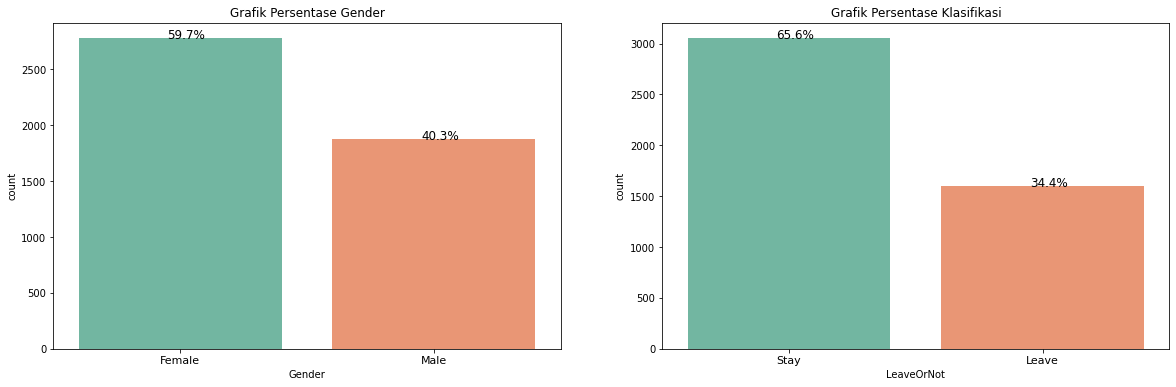

In [5]:
plt.figure(figsize=(20, 6))
plt.subplot(1,2,1)
plt.title('Grafik Persentase Gender')
ax = sns.countplot(data=data, x='Gender', palette='Set2')
without_hue(ax, data.Gender)
plt.xticks([0,1],['Female','Male'], fontsize = 11)

plt.subplot(1,2,2)
plt.title('Grafik Persentase Klasifikasi')
ax = sns.countplot(data=data, x='LeaveOrNot', palette='Set2')
without_hue(ax, data.LeaveOrNot)
plt.xticks([0,1],['Stay','Leave'], fontsize = 11)

- Dilihat dari grafik persentase gender, terlihat wanita lebih dominan dengan 57.9%  sedangkan pria hanya 40.3% dari data.
- 34.4% dari data adalah karyawan yang diprediksi akan resign sebesar 34.4% dan yang akan bertahan di perushaan sebesar 65.6%

Meliahat apakah gender berperan dalam seorang karyawan akan resi berhenti berkerja atau tidak.

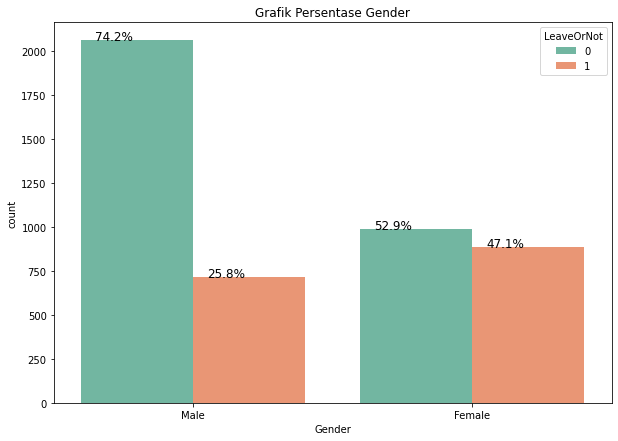

In [6]:
plt.figure(figsize=(10,7))
plt.title('Grafik Persentase Gender')
ax = sns.countplot(data=data, x='Gender', palette='Set2', hue='LeaveOrNot')
with_hue(ax, data.Gender, 2,2)

- 74.2% karyawan pria diprediksi akan bertahan di perusahaan dan 25.8% akan berhenti, sedangkan 52.9% karyawan wanita akan bertahan di perusahaan dan sebesar 47.1% karyawan wanita akan berhenti dari perusahaan. dari data tersebut dapat dilihat persentase wanita yang akan berhenti lebih tinggi dari pria. Terdapat beberapa kemungkinan kenapa persentase wanita lebih banyak resign daripada pria, salah satunya mungkin setelah menikah dan punya anak wanita cenderung akan resign karena ingin fokus mengurus anak dan menjadi ibu rumah tangga.

Melihat persentase tingkat pendidikan dan hubungannya dengan label

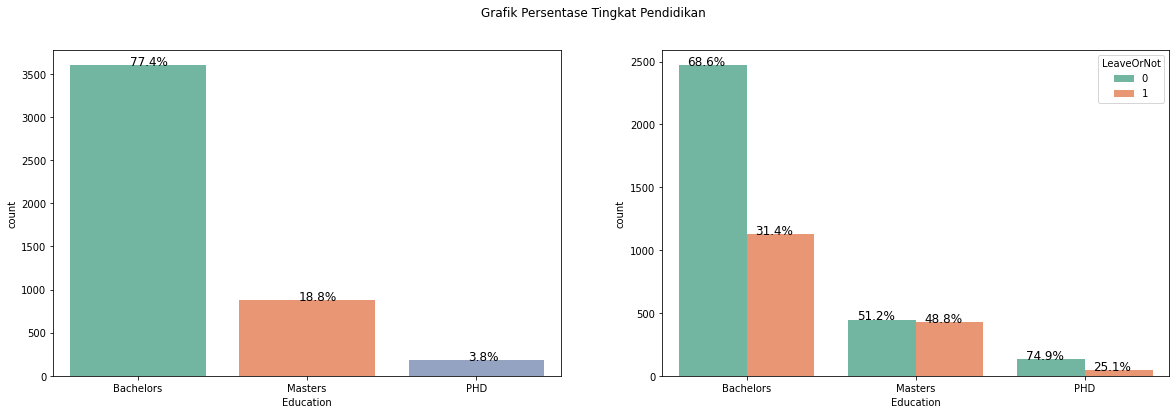

In [7]:
plt.figure(figsize=(20, 6))
plt.suptitle('Grafik Persentase Tingkat Pendidikan')
plt.subplot(1,2,1)
ax = sns.countplot(data=data, x='Education', palette='Set2')
without_hue(ax, data.ExperienceInCurrentDomain)

plt.subplot(1,2,2)
ax = sns.countplot(data=data, x='Education', palette='Set2', hue='LeaveOrNot')
with_hue(ax, data.Education, 3,2)

- Berdasarkan Grafik Persentase Tingkat Pendidikan, Bachelor atau Sarjana menjadi tingkat pendidikan paling tinggi yang terdapat pada data dengan 77.4% diikuti dengan Master dengan 18.8% dan paling kecil PhD atau Doktor dengan 3.8%.
- Pada tingkat pendidikan Sarjana, sebesar 31.4% karyawan akan berhenti dari perusahaan dan 68.6% akan tetap bekerja di perusahaan, pada tingkatan Master 51.2% karyawan memilih tetap bekerja dan 48.8% memilih berhenti dan pada tingkat pendidikan Doktor, sebesar 74.9% memilih tetap bekerja dan 25.1% akan resign. Berdasarkan data tersebut dapat dilihat persentase karyawan yang resign dengan tingkat pendidikan Master lebih tinggi dari tingkat pendidikan lainnya.

Melihat persentase pengalaman di domain saat ini dan hubungannya dengan label

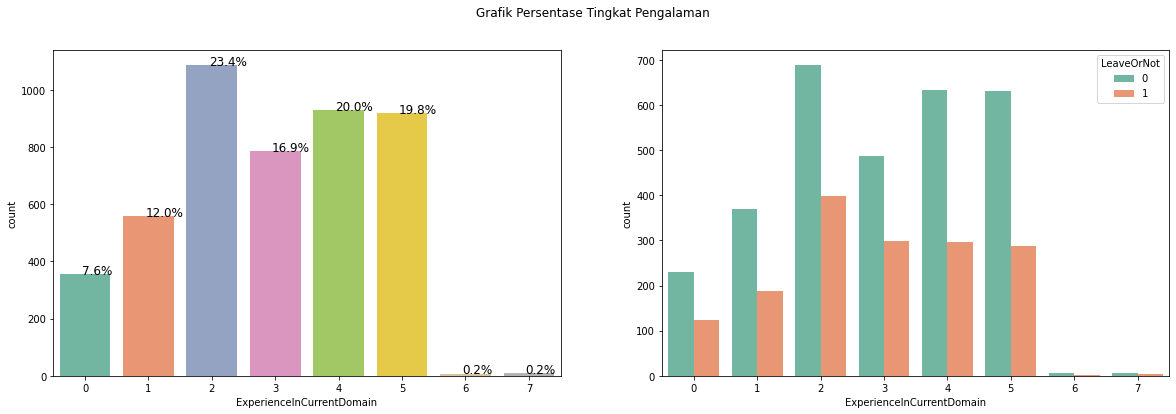

In [8]:
plt.figure(figsize=(20, 6))
plt.suptitle('Grafik Persentase Tingkat Pengalaman')
plt.subplot(1,2,1)
ax = sns.countplot(data=data, x='ExperienceInCurrentDomain', palette='Set2')
without_hue(ax, data.ExperienceInCurrentDomain)

plt.subplot(1,2,2)
ax = sns.countplot(data=data, x='ExperienceInCurrentDomain', palette='Set2', hue= "LeaveOrNot")


- Bersarkan Grafik Persentase Tingkat Pengalaman, dapat dilihat karyawan dengan pengalaman 2 tahun menjadi yang tertinggi dari yang lainnya dengan 23.4%, diikuti dengan pengalaman 4 tahun dengan 20% dan yang terkecil adalah pengalaman 6 dan 7 tahun dengan 0.2%.
- Persentase orang yang resign terlihat seimbang antar variable, tetapi pada tingkat pengalaman 3 tahun terlihat selisih persentase karyawan yang resign dan tidaknya lebih sedikit dibanding tingkat pengalaman lainnya. Dan sangat sedikit karyawan yang bertahan hingga tahun ke 6 dan 7 di perusahaan.

Apakah tingkat pendidikan dan pengalaman kerja berpengaruh terhadap tingkatan gaji?

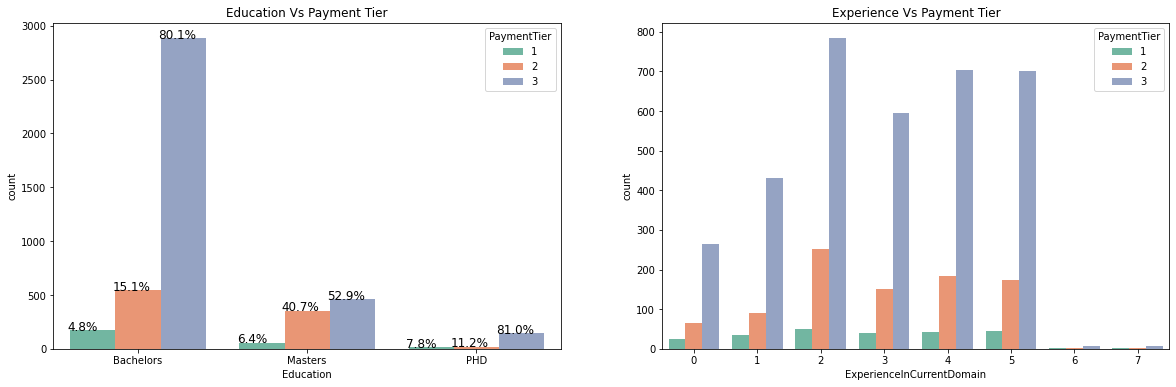

In [9]:
plt.figure(figsize=(20, 6))
plt.subplot(1,2,1, title='Education Vs Payment Tier')
ax = sns.countplot(data=data, x='Education', palette='Set2', hue='PaymentTier')
with_hue(ax, data.Education, 3,3)

plt.subplot(1,2,2, title='Experience Vs Payment Tier')
ax = sns.countplot(data=data, x='ExperienceInCurrentDomain', palette='Set2', hue= "PaymentTier")

- Pada grafik Education Vs Payment Tier dapat dilihat tingkat pendidikan tidak terlalu berpengaruh terhadap gaji, dimana banyak karyawan yang hanya bergelar sarjana tetap memiliki gaji tinggi.
- Pada grafik Experience vs Payment dapat dilihat karyawan dengan tingkat pengalaman 2 tahun mendapat gaji tinggi lebih banyak dari tingkat pengalaman lainnya, tetapi tingkat pengalaman kerja di suatu domain tidak berpengaruh signifikan terhadap gaji yang didapat.

Melihat persentase tahun bergabung dan pengaruhnya terhadap label

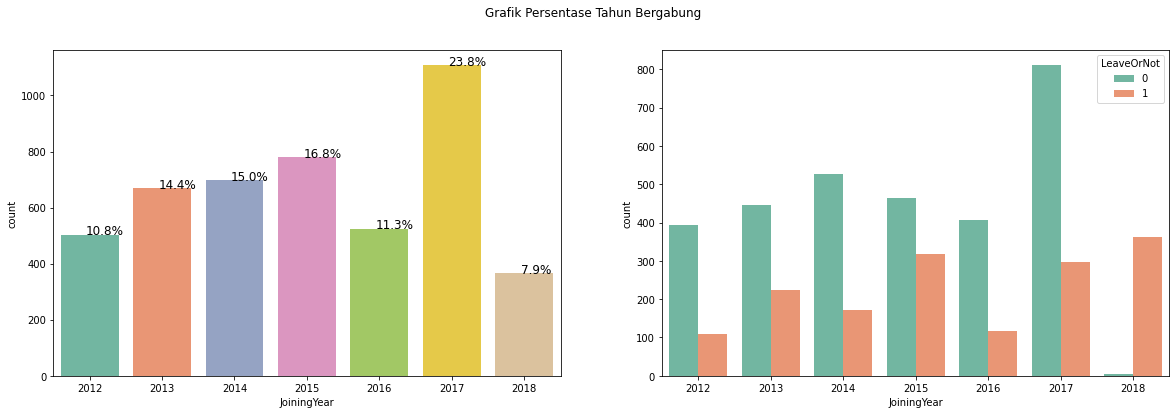

In [10]:
plt.figure(figsize=(20, 6))
plt.suptitle('Grafik Persentase Tahun Bergabung')
plt.subplot(1,2,1)
ax = sns.countplot(data=data, x='JoiningYear', palette='Set2')
without_hue(ax, data.JoiningYear)

plt.subplot(1,2,2)
ax = sns.countplot(data=data, x='JoiningYear', palette='Set2', hue= "LeaveOrNot")

- Berdsarikan Grafik Persentase Tahun Bergabung, terlihat bahwa banyak karyawan yang bergabung pada tahun 2017 dengan persentase 23.8% dan diikuti dengan tahun 2015 dengan 16.8%, dan yang terendah ada pada tahun 2018 dengan 7.9%.
- Tahun 2018 juga menjadi tahun dengan selisih persentase karyawan resign tertinggi dibandingkan dengan tahun lainnya, dimana persentase karyawan resign mencapai >90% dibandingkan dengan karyawan yang bertahan di perusahaan.

Apakah karyawan yang meninggalkan project kantor berpengaruh pada label?

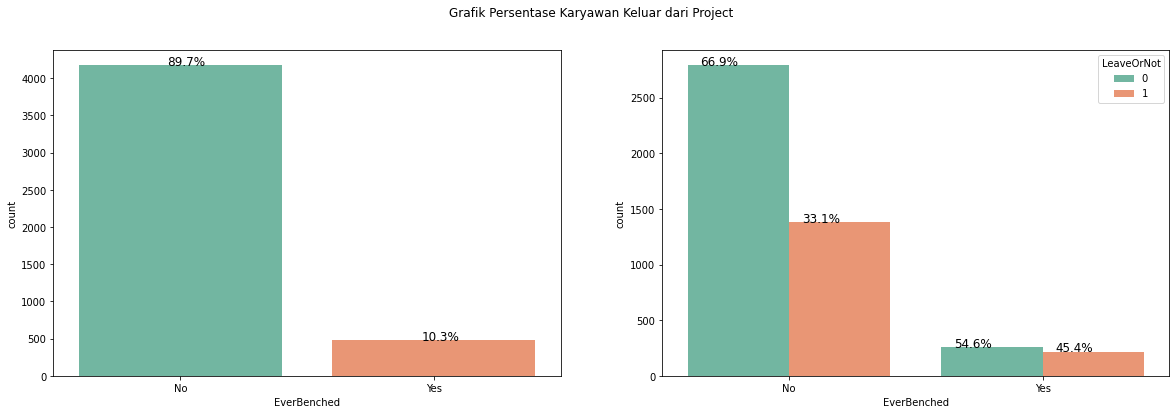

In [11]:
plt.figure(figsize=(20,6))
plt.suptitle('Grafik Persentase Karyawan Keluar dari Project ')
plt.subplot(1,2,1)
ax = sns.countplot(data=data, x='EverBenched', palette='Set2')
without_hue(ax, data.EverBenched)

plt.subplot(1,2,2)
ax = sns.countplot(data=data, x='EverBenched', palette='Set2', hue='LeaveOrNot')
with_hue(ax, data.EverBenched,2,2)

- Berdasarkan Grafik Persentase Karyawan Keluar dari Project, sebesar 87.7% karyawan tidak pernah keluar dari project yang dikerjakan, dan sebanyak 10.3% pernah meninggalkan project yang dikerjakan. Dari 10.3% itu sebanyak 54.6% karyawan bertahan kerja di perusahaan dan 45.4% lainnya resign dari perusahaan. Pernah atau tidaknya seorang karyawan keluar dari sebuah project berpengaruh terhadap karyawan tersebut akan resign atau tidak dari perusahaan, dimana persentase karyawan yang tidak pernah keluar dari project dan resign dari perusahaan lebih kecil dibandingkan dengan karyawan yang pernah meniggalkan project perusahaan.

Apakah tingakatan gaji berpengaruh terhadap label?

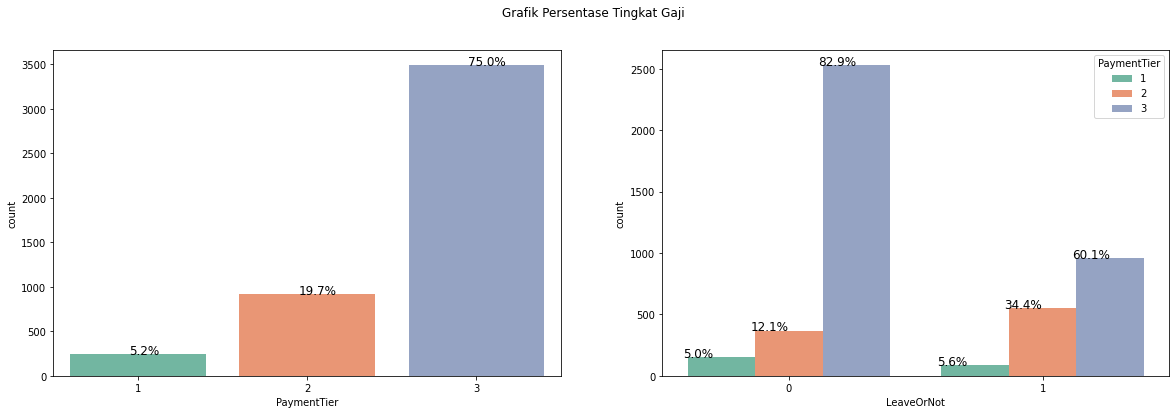

In [12]:
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.suptitle('Grafik Persentase Tingkat Gaji')
ax = sns.countplot(data=data, x='PaymentTier', palette='Set2')
without_hue(ax, data.PaymentTier)

plt.subplot(1,2,2)
ax = sns.countplot(data=data, x='LeaveOrNot', palette='Set2', hue='PaymentTier')
with_hue(ax, data.LeaveOrNot,2,3)

- Bedasarkan Grafik Persentase Tingkat Gaji, dapat dilihat karyawan dengan gaji tingkat 3 (tinggi) lebih banyak dari tingkatan lainnya dengan persentase 75% dari data, tingkat 2(sedang) sebesar 19.7 dan tingkat 1 (rendah) sebesar 5.2%.
- Karyawan dengan gaji tingkat 3 cenderung bertahan di perusahaan. Dan persentase karyawan tier 2 yang resign dari perusahaan lebig tinggi daripada yang bertahan di perusahaan. Ada indikasi karyawan dengan gaji tingkat 2 yang resign tidak puas dengan gaji yang didapatnya di perusahaan dan mencoba mencari perusahaan lain yang menawarkan gaji yang lebih tinggi.

<AxesSubplot:>

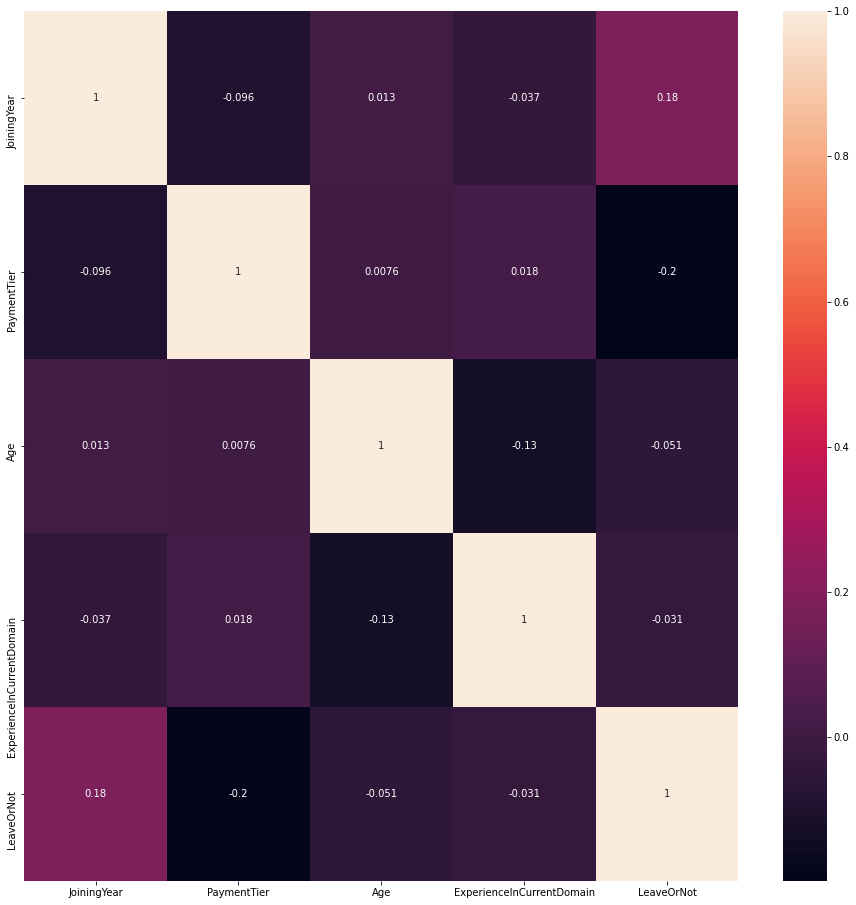

In [13]:
plt.figure(figsize=(16,16))
sns.heatmap(data.corr(), annot=True)

- Bersarkan grafik heatmap, Payment Tier memiliki korelasi yang tinggi dengan label LeaveOrNot, dengan nilai korelasi sebesar -0.2 den label LeaveOrNot memiliki korelasi paling rendah dengan kolom ExperienceInCurrentDomain dengan poin korelasi sebesar -0.031.

# Data Preprocessing

## Memisakan Data untuk Model Inference

Membagi data inference untuk menguji model dengan data baru.

In [14]:
# Membagi data Inference dan Data train_test
data_inf = data.sample(20, random_state=4)
data_train_test = data.drop(data_inf.index)
# Reset index pada data Inference dan Data train_test
data_inf.reset_index(drop=True, inplace=True) 
data_train_test.reset_index(drop=True, inplace=True)

data_train_test

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0
1,Bachelors,2013,Pune,1,28,Female,No,3,1
2,Bachelors,2014,New Delhi,3,38,Female,No,2,0
3,Masters,2016,Bangalore,3,27,Male,No,5,1
4,Masters,2017,Pune,3,24,Male,Yes,2,1
...,...,...,...,...,...,...,...,...,...
4628,Bachelors,2013,Bangalore,3,26,Female,No,4,0
4629,Masters,2013,Pune,2,37,Male,No,2,1
4630,Masters,2018,New Delhi,3,27,Male,No,5,1
4631,Bachelors,2012,Bangalore,3,30,Male,Yes,2,0


## Memisahkan Feature (X) dan label (y)

Melakukan splitting data X (Feature), y (label/target), yang menjadi target adalah kolom income_bracket

In [15]:
# X : Feature
# y : label/target
X = data_train_test.drop('LeaveOrNot', axis=1)
y = data_train_test['LeaveOrNot']
X.head(2)

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain
0,Bachelors,2017,Bangalore,3,34,Male,No,0
1,Bachelors,2013,Pune,1,28,Female,No,3


Memisahkan data train dan test

In [16]:
# Memisahkan data Train dan Test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=21)

print('Train Size : ', X_train.shape)
print('Test Size  : ', X_test.shape)
print('Test Size  : ', y_train.shape)
print('Test Size  : ', y_test.shape)

Train Size :  (3474, 8)
Test Size  :  (1159, 8)
Test Size  :  (3474,)
Test Size  :  (1159,)


Mendefinisikan numerical column untuk dilakukan distribusi data, outlier handling dan missing value handling

In [17]:
# Numerical Column 
numerical_col = X_train[['Age','ExperienceInCurrentDomain']]

Melakukan pengecekan distribusi data

In [18]:
# Input Paramater Distribution  Check
dis_check = numerical_col.skew()

normal_dis = []
skew_dis = []

for i in range(len(dis_check)):
    if dis_check.values[i] < -0.5:
        skew_dis.append(dis_check.index[i])
    elif dis_check.values[i] > 0.5:
        skew_dis.append(dis_check.index[i])
    else:
        normal_dis.append(dis_check.index[i])

Melihat distribusi data

In [19]:
# Skew dist
print('skew_dist :', skew_dis)
print("===================" *10)
# normal_dist
print('normal_dist :',normal_dis)
print("===================" *10)

skew_dist : ['Age']
normal_dist : ['ExperienceInCurrentDomain']


- Kolom 'Age' merupakan skewed distribution data, dan kolom ExperienceInCurrentDomain normal distribution data.

## Handle Outlier

In [20]:
X_train.describe()

,JoiningYear,PaymentTier,Age,ExperienceInCurrentDomain
count,3474.000000,3474.000000,3474.000000,3474.000000
mean,2015.050086,2.698330,29.422280,2.899539
std,1.853494,0.562237,4.863632,1.557233
min,2012.000000,1.000000,22.000000,0.000000
25%,2013.000000,3.000000,26.000000,2.000000
50%,2015.000000,3.000000,28.000000,3.000000
75%,2017.000000,3.000000,33.000000,4.000000
max,2018.000000,3.000000,41.000000,7.000000


In [21]:
# Outliers Detection Function
# for Normally Distributed Data

def detect_normal(df, parameter):
    
    threshold = 3
    mean_ = np.mean(df[parameter])
    std_ = np.std(df[parameter])

    upper_count = df[
                    ((df[parameter]-mean_)/std_) > threshold
                    ][parameter].count()

    bottom_count = df[
                    ((df[parameter]-mean_)/std_) < -threshold
                    ][parameter].count()

    total_count = upper_count + bottom_count

    percentage = (total_count/len(df[parameter])*100).round(2)

    a = ({'Parameter':parameter, 'Total Outliers':total_count, 'Percentage':percentage})

    return print(a)

In [22]:
# Outliers Detection Function
# for Skew Distributed Data

def detect_skew(df, parameter, fold=1.5):
    
    for i in parameter:
        
        IQR = df[parameter].quantile(0.75) - df[parameter].quantile(0.25)
        upper = df[parameter].quantile(0.75) + (fold*IQR)
        bottom = df[parameter].quantile(0.25) - (fold*IQR)

        upper_count = df[
            (df[parameter] > upper)
        ][parameter].count()

        bottom_count = df[
            (df[parameter] < bottom)
        ][parameter].count()
        
        total_count = upper_count + bottom_count

        percentage = (total_count/len(df[parameter])*100).round(2)

        a = ({'Parameter':parameter, 'Total Outliers':total_count, 'Percentage':percentage})

    return print(a)

Check Oulier Normal Dist Data

In [23]:
# Outlier summary
# For normally distributed input parameter

for i in normal_dis:
    detect_normal(X_train, parameter=i)

{'Parameter': 'ExperienceInCurrentDomain', 'Total Outliers': 0, 'Percentage': 0.0}


Check outlier Skewed Dist Data

In [24]:
# Outlier summary
# For skew distributed input parameter

for i in skew_dis:
    detect_skew(X_train, parameter=i)

{'Parameter': 'Age', 'Total Outliers': 0, 'Percentage': 0.0}


- Tidak terdapat outlier pada data

## Handling Missing Value

In [25]:
# create function to detect missing values

def detect_missval(df):
    global df_missval
    df_missval = pd.DataFrame(columns=['col_name','missing_count','missing_percentage'])
    for i in range(len(df.columns)):
        if df.iloc[:,i].isnull().sum() != 0:
            df_missval.loc[i] = [df.columns[i], # col_name
                                df.iloc[:,i].isnull().sum(), # missing_count
                                df.iloc[:,i].isnull().sum()/len(df.iloc[:,i])*100] # missing_percentage
    print('Generate df_missval')
    return df_missval

Deteksi missing value pada train set

In [26]:
# X_train Set
detect_missval(X_train)

Generate df_missval


,col_name,missing_count,missing_percentage


Deteksi missing value pada test set


In [27]:
# X_test Set
detect_missval(X_test)

Generate df_missval


,col_name,missing_count,missing_percentage


In [28]:
# y_train
print('y_train: ',y_train.isna().sum())
# y_test
print('y_test: ', y_test.isna().sum())

y_train:  0
y_test:  0


- Tidak terdapat missing value pada data

## Columns categorization

Memisahkan numerical column, dan categorical column nominal dan ordinal

In [29]:
data.head(2)

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0
1,Bachelors,2013,Pune,1,28,Female,No,3,1


In [30]:
# Numerical Column Normal
numerical = X_train[['Age','ExperienceInCurrentDomain']].columns.tolist()

# Cat column nominal
categorical_nom = X_train[['JoiningYear','Gender','City']].columns.tolist()

# Cat column ordinal
categorical_or = X_train[[ 'Education', 'PaymentTier','EverBenched']].columns.tolist()


## Feature Engineer

In [31]:
# Menggunakan MinMaxScaller karena data numerical dominan skewed distribution
numerical_pipe = make_pipeline(MinMaxScaler())

# Menggunakan OneHotEncoder untuk data categorical nominal
nominal_pipe = make_pipeline(OneHotEncoder())

# Menggunakan OrdinalEncoder untuk data categorical ordinal
ordinal_pipe = make_pipeline(OrdinalEncoder())

data_pipeline = ColumnTransformer([
    ('numerical_pipe', numerical_pipe, numerical),
    ('nominal_pipe', nominal_pipe, categorical_nom),
    ('ordinal_pipe', ordinal_pipe, categorical_or)])

## Balancing Data

Melakukan balancing data pada train set, karena data memiliki target tidak seimbang antarkelasnya, dilakukan balancing data agar model dapat belajar lebih banyak pada kelas minoritas

In [32]:
smote = SMOTENC(random_state = 11, categorical_features=[0,1,2,3,5,6])
X_train, y_train = smote.fit_resample(X_train, y_train)

# Model Definition

Melakukan deklarasi model dengan Logistic Regression dan SVM Classification, Random Forest, Ada Boost, dan XGBoost model dibungkus dengan pipeline

In [33]:
# Model Logistic Regression
log_pipeline = make_pipeline(data_pipeline, LogisticRegression(random_state=2))

# Model Ada SVC
svm_pipeline = make_pipeline(data_pipeline, SVC(random_state=2))

# Model Random Forest
rf_pipeline = make_pipeline(data_pipeline, RandomForestClassifier(random_state=2))

# Model Ada Boost
ada_pipeline = make_pipeline(data_pipeline, AdaBoostClassifier(random_state=2))

# Model XGBoost
xgb_pipeline = make_pipeline(data_pipeline, XGBClassifier(random_state=2))

# Model Training

Melakukan training model dengan data X_train dan y_train

## Logistic Regression

In [34]:
log_pipeline.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numerical_pipe',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['Age',
                                                   'ExperienceInCurrentDomain']),
                                                 ('nominal_pipe',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  ['JoiningYear', 'Gender',
                                                   'City']),
                                                 ('ordinal_pipe',
                                                  Pipeline(steps=[('ordinalencoder',
                                                            

## SVM

In [35]:
svm_pipeline.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numerical_pipe',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['Age',
                                                   'ExperienceInCurrentDomain']),
                                                 ('nominal_pipe',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  ['JoiningYear', 'Gender',
                                                   'City']),
                                                 ('ordinal_pipe',
                                                  Pipeline(steps=[('ordinalencoder',
                                                            

## Random Forest

In [36]:
rf_pipeline.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numerical_pipe',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['Age',
                                                   'ExperienceInCurrentDomain']),
                                                 ('nominal_pipe',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  ['JoiningYear', 'Gender',
                                                   'City']),
                                                 ('ordinal_pipe',
                                                  Pipeline(steps=[('ordinalencoder',
                                                            

## Ada Boost Classifier

In [37]:
ada_pipeline.fit(X_train,y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numerical_pipe',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['Age',
                                                   'ExperienceInCurrentDomain']),
                                                 ('nominal_pipe',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  ['JoiningYear', 'Gender',
                                                   'City']),
                                                 ('ordinal_pipe',
                                                  Pipeline(steps=[('ordinalencoder',
                                                            

## XGBoost Clasifier

In [38]:
xgb_pipeline.fit(X_train,y_train)

[16:40:07] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\rioar\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numerical_pipe',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['Age',
                                                   'ExperienceInCurrentDomain']),
                                                 ('nominal_pipe',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  ['JoiningYear', 'Gender',
                                                   'City']),
                                                 ('ordinal_pipe',
                                                  Pipeline(steps=[('ordinalencoder',
                                                            

# Model Evaluation

Melakukan evaluasi untuk melihat performa dari model

In [39]:
#Performance Metrics
print('ROC AUC Train Results Logistic Regression')
print(roc_auc_score(y_train, log_pipeline.predict(X_train)))

print('ROC AUC Test Results Logistic Regression')
print(roc_auc_score(y_test, log_pipeline.predict(X_test)))
print ('-------------------------------------------------')

print('ROC AUC Train Results SVM')
print(roc_auc_score(y_train, svm_pipeline.predict(X_train)))

print('ROC AUC Test Results SVM')
print(roc_auc_score(y_test, svm_pipeline.predict(X_test)))
print ('-------------------------------------------------')

print('ROC AUC Train Results Random Forest')
print(roc_auc_score(y_train, rf_pipeline.predict(X_train)))

print('ROC AUC Test Results Random Forest')
print(roc_auc_score(y_test, rf_pipeline.predict(X_test)))
print ('-------------------------------------------------')

print('ROC AUC Train Results Ada Boost')
print(roc_auc_score(y_train, ada_pipeline.predict(X_train)))

print('ROC AUC Test Results Ada Boost')
print(roc_auc_score(y_test, ada_pipeline.predict(X_test)))
print ('-------------------------------------------------')

print('ROC AUC Train Results XGBoost')
print(roc_auc_score(y_train, xgb_pipeline.predict(X_train)))

print('ROC AUC Test Results XGBoost')
print(roc_auc_score(y_test, xgb_pipeline.predict(X_test)))

ROC AUC Train Results Logistic Regression
0.7635017421602788
ROC AUC Test Results Logistic Regression
0.7238768184149198
-------------------------------------------------
ROC AUC Train Results SVM
0.8334059233449477
ROC AUC Test Results SVM
0.7989827911898163
-------------------------------------------------
ROC AUC Train Results Random Forest
0.9268292682926829
ROC AUC Test Results Random Forest
0.7800651091535811
-------------------------------------------------
ROC AUC Train Results Ada Boost
0.7831010452961673
ROC AUC Test Results Ada Boost
0.7403731929451018
-------------------------------------------------
ROC AUC Train Results XGBoost
0.9037456445993032
ROC AUC Test Results XGBoost
0.8007127602256425


- Ditinjau berdasarkan score ROC-AUC nya model random forest menjadi model dengan nilai roc-auc paling tinggi dibandingkan model lainnya, dengan nilai roc-auc pada train set sebesar 0.92 dan test set sebesar 0.78, perbedaan nilai tersebut diakibatkan karena pada train set dilakukan smote, setelah dilakukan smote data kelas 0 dan 1 nya seimbang sehingga membuat nilai roc-aucnya tinggi.
- Nilai ROC XGBoost menjadi yang tertinggi di test set dibandingkan dengan model lainnya dengan nilai 0.8, dan model logistic menjadi yang terendah nilai roc-auc pada test set dengan 0.72.

In [40]:
print('ROC AUC Train Results Random Forest with Hyperparameter Tuning')
print(classification_report(y_train, xgb_pipeline.predict(X_train)))

print('ROC AUC Test Results Random Forest with Hyperparameter Tuning')
print(classification_report(y_test, xgb_pipeline.predict(X_test)))

ROC AUC Train Results Random Forest with Hyperparameter Tuning
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      2296
           1       0.93      0.87      0.90      2296

    accuracy                           0.90      4592
   macro avg       0.91      0.90      0.90      4592
weighted avg       0.91      0.90      0.90      4592

ROC AUC Test Results Random Forest with Hyperparameter Tuning
              precision    recall  f1-score   support

           0       0.85      0.88      0.87       746
           1       0.77      0.72      0.74       413

    accuracy                           0.82      1159
   macro avg       0.81      0.80      0.81      1159
weighted avg       0.82      0.82      0.82      1159



# Cross Validation

Melakukan Cross Validation pada semua model untuk melihat model mana yang paling baik dalam memprediksi model, CV dilakukan sebanyak 5 kali dengan roc-auc sebagai metric penilaiannya

In [41]:
# Cross-validate base model

# prepare models and put it into list
models = []
models.append(("Logistic", log_pipeline))
models.append(("SVM", svm_pipeline))
models.append(("Random Forest", rf_pipeline))
models.append(("Ada Boost", ada_pipeline))
models.append(("XGBoost", xgb_pipeline))

# Create empty list to stores result
names = []
results = []
mean_score = []
stdev_score = []

# Cross-validate each model
for name, model in models:
    model.fit(X_train,y_train)
    scores = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=5, n_jobs=-1)

    names.append(name)
    results.append(scores)
    mean_score.append(round(np.mean(scores),4))
    stdev_score.append(round(np.std(scores),4))

cv_result = pd.DataFrame({'models':names, 'mean_score':mean_score, 'stdev_score':stdev_score})

c:\Users\rioar\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:40:14] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Melihat hasil cross validation


In [42]:
cv_result.sort_values(by='mean_score', ascending=False)

,models,mean_score,stdev_score
4,XGBoost,0.9227,0.0267
2,Random Forest,0.9176,0.0307
1,SVM,0.8834,0.0163
3,Ada Boost,0.8417,0.0260
0,Logistic,0.8154,0.0202


- Setelah dilakukan cross validation, model XGBoost menadapatkan nilai rata-rata tertinggi dibandingkan model lainnya, dengan nilai 0.9227 +- 0.0267 untuk batas atas dan bawahnya, diikuti dengan model random forest dengan mean score 0.9176 +- 0.0307 untuk batas atas dan bawahnya.

# Model Improvement

Melakukan model improvement dengan hyperparameter tuning menggunakan gridsearch.

In [43]:
model = rf_pipeline
rf_param=[{
    'randomforestclassifier__criterion': ['gini', 'entropy'],
    'randomforestclassifier__n_estimators': [10,30, 50, 100,150,200],
    'randomforestclassifier__min_samples_split': [2, 4, 8, 16, 32, 64],
    'randomforestclassifier__max_features': ['auto', 'sqrt', 'log2'],
    'randomforestclassifier__max_features': [2, 3, 4, 5, 6, 7, 8]
}]

cv = RepeatedStratifiedKFold(n_splits=10,n_repeats=3)
grid_search_rf = GridSearchCV(estimator=model, param_grid=rf_param, n_jobs=-1,cv=cv, scoring='roc_auc', error_score=8)
grid_result_rf = grid_search_rf.fit(X_train,y_train)

print("Best:%fusing%s" % (grid_search_rf.best_score_,grid_search_rf.best_params_))
means = grid_search_rf.cv_results_['mean_test_score']        
stds = grid_search_rf.cv_results_['std_test_score']
params = grid_search_rf.cv_results_['params']
for mean, stdev, param in zip(means,stds,params):
    print(" %f (%f) with: %r" %(mean,stdev,param))

Best:0.923435using{'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_features': 8, 'randomforestclassifier__min_samples_split': 8, 'randomforestclassifier__n_estimators': 200}
 0.904224 (0.009596) with: {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_features': 2, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 10}
 0.909786 (0.009476) with: {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_features': 2, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 30}
 0.911601 (0.009774) with: {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_features': 2, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 50}
 0.912540 (0.010175) with: {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_features': 2, 'randomforestclassifier__min_samples_split': 2, 'randomfo

- Setelah dilakukan hyperparameter tuning, didapatkan hyperparameter terbaik untuk random forest,'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_features': 8, 'randomforestclassifier__min_samples_split': 8, 'randomforestclassifier__n_estimators': 200, 
dengan parameter tersebut mendapatkan rata-rata nilai roc-auc sebesar 0.924376

Melakukan prediksi grid_search best_estimator

In [44]:
y_pred_train_rf_best=grid_search_rf.best_estimator_.predict(X_train)
y_pred_test_rf_best=grid_search_rf.best_estimator_.predict(X_test)

Melihat hasil prediksi

In [45]:
#Performance Metrics
print('ROC AUC Train Results Random Forest')
print(roc_auc_score(y_train, rf_pipeline.predict(X_train)))

print('ROC AUC Test Results Random Forest')
print(roc_auc_score(y_test, rf_pipeline.predict(X_test)))
print ('-------------------------------------------------')

print('ROC AUC Train Results Random Forest with Hyperparameter Tuning')
print(roc_auc_score(y_train, y_pred_train_rf_best))

print('ROC AUC Test Results Random Forest with Hyperparameter Tuning')
print(roc_auc_score(y_test, y_pred_test_rf_best))

ROC AUC Train Results Random Forest
0.9268292682926829
ROC AUC Test Results Random Forest
0.7800651091535811
-------------------------------------------------
ROC AUC Train Results Random Forest with Hyperparameter Tuning
0.9057055749128922
ROC AUC Test Results Random Forest with Hyperparameter Tuning
0.7901187284565301


- Setelah dilakukan hyperparameter tuning, selisih antara nilai train dan test sudah berkurang, dan terdapat kenaikan nilai roc-auc sebesar 0.01 atau 1% pada test set setelah dilakukan hyperparameter tuning

In [46]:
model = xgb_pipeline
xgb_param=[{
    'xgbclassifier__n_estimators': [10,30, 50, 100,150,200],
    'xgbclassifier__max_depth':[ 10, 15,17,19,21,23,28,30],
    'xgbclassifier__booster' :['gbtree','gblinear'],
    'xgbclassifier__tree_method' :['exact']
    }]

cv = RepeatedStratifiedKFold(n_splits=5)
grid_search_xgb = GridSearchCV(estimator=model, param_grid=xgb_param, n_jobs=-1,cv=cv, scoring='roc_auc', error_score=8)
grid_result_xgb = grid_search_xgb.fit(X_train,y_train)

print("Best:%fusing%s" % (grid_result_xgb.best_score_,grid_result_xgb.best_params_))
means = grid_result_xgb.cv_results_['mean_test_score']        
stds = grid_result_xgb.cv_results_['std_test_score']
params = grid_result_xgb.cv_results_['params']
for mean, stdev, param in zip(means,stds,params):
    print(" %f (%f) with: %r" %(mean,stdev,param))

[16:54:42] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best:0.922385using{'xgbclassifier__booster': 'gbtree', 'xgbclassifier__max_depth': 10, 'xgbclassifier__n_estimators': 30, 'xgbclassifier__tree_method': 'exact'}
 0.919249 (0.008501) with: {'xgbclassifier__booster': 'gbtree', 'xgbclassifier__max_depth': 10, 'xgbclassifier__n_estimators': 10, 'xgbclassifier__tree_method': 'exact'}
 0.922385 (0.008836) with: {'xgbclassifier__booster': 'gbtree', 'xgbclassifier__max_depth': 10, 'xgbclassifier__n_estimators': 30, 'xgbclassifier__tree_method': 'exact'}
 0.921885 (0.008768) with: {'xgbclassifier__booster': 'gbtree', 'xgbclassifier__max_depth': 10, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__tree_method': 'exact'}
 0.920216 (0.009057) with: {'xgbclassifier__booster': 'gbtree', 'xgbclassifie

c:\Users\rioar\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


- Setelah dilakukan hyperparameter tuning, didapatkan hyperparameter terbaik untuk XGBoost adalah, 'xgbclassifier__booster': 'gbtree', 'xgbclassifier__max_depth': 10, 'xgbclassifier__n_estimators': 30, 'xgbclassifier__tree_method': 'exact', dengan parameter tersebut mendapatkan rata-rata nilai roc-auc sebesar 0.922462

Melakukan prediksi grid_search best_estimator

In [47]:
y_pred_train_xgb_best= grid_search_xgb.best_estimator_.predict(X_train)
y_pred_test_xgb_best= grid_search_xgb.best_estimator_.predict(X_test)

Melihat hasil prediksi

In [48]:
#Performance Metrics
print('ROC AUC Train Results XGBoost')
print(roc_auc_score(y_train, xgb_pipeline.predict(X_train)))

print('ROC AUC Test Results XGBoost')
print(roc_auc_score(y_test,xgb_pipeline.predict(X_test)))
print ('-------------------------------------------------')

print('ROC AUC Train Results XGBoost with Hyperparameter Tuning')
print(roc_auc_score(y_train, y_pred_train_xgb_best))

print('ROC AUC Test Results XGBoost with Hyperparameter Tuning')
print(roc_auc_score(y_test, y_pred_test_xgb_best))

ROC AUC Train Results XGBoost
0.9037456445993032
ROC AUC Test Results XGBoost
0.8007127602256425
-------------------------------------------------
ROC AUC Train Results XGBoost with Hyperparameter Tuning
0.9087543554006968
ROC AUC Test Results XGBoost with Hyperparameter Tuning
0.7987020363650527


- Terdapat sedikit perbedaan setelah dilakukan hyperparameter tuning, dimana pada train set terjadi sedikit peningkatan dan test set sedikit penurunan score roc-auc

Membadingkan model Random Forest dan XGBoost setelah dilakukan hyperparameter tuning.

In [49]:
#Performance Metrics
print('ROC AUC Score Train Results Random Forest')
print(roc_auc_score(y_train, y_pred_train_rf_best))

print('ROC AUC Score Test Results Random Forest')
print(roc_auc_score(y_test, y_pred_test_rf_best))
print ('-------------------------------------------------')

print('ROC AUC Score Train Results XGBoost')
print(roc_auc_score(y_train, y_pred_train_xgb_best))

print('ROC AUC Score Test Results XGBoost')
print(roc_auc_score(y_test, y_pred_test_xgb_best)) 

ROC AUC Score Train Results Random Forest
0.9057055749128922
ROC AUC Score Test Results Random Forest
0.7901187284565301
-------------------------------------------------
ROC AUC Score Train Results XGBoost
0.9087543554006968
ROC AUC Score Test Results XGBoost
0.7987020363650527


In [50]:
#Performance Metrics
print('Recall Score Train Results Random Forest')
print(recall_score(y_train, y_pred_train_rf_best))

print('Recall Score Test Results Random Forest')
print(recall_score(y_test, y_pred_test_rf_best))
print ('-------------------------------------------------')

print('Recall Score Train Results XGBoost')
print(recall_score(y_train, y_pred_train_xgb_best))

print('Recall Score Test Results XGBoost')
print(recall_score(y_test, y_pred_test_xgb_best))

Recall Score Train Results Random Forest
0.8815331010452961
Recall Score Test Results Random Forest
0.7142857142857143
-------------------------------------------------
Recall Score Train Results XGBoost
0.877177700348432
Recall Score Test Results XGBoost
0.7167070217917676


- Berdasarkan nilai roc-auc dan recall, terlihat model xgb sedikit lebih unggul dari model random forest, jadi model XGBOost setelah dilakukan hyperparameter tuning dipilih untuk menjadi model final

In [51]:
print ('Clasification Report Train Set')
print(classification_report(y_train,y_pred_train_xgb_best , target_names=['Stay', 'Leave']))
print('-'*60)
print ('Clasification Report Test Set')
print(classification_report(y_test,y_pred_test_xgb_best ,  target_names=['Stay', 'Leave']))

Clasification Report Train Set
              precision    recall  f1-score   support

        Stay       0.88      0.94      0.91      2296
       Leave       0.94      0.88      0.91      2296

    accuracy                           0.91      4592
   macro avg       0.91      0.91      0.91      4592
weighted avg       0.91      0.91      0.91      4592

------------------------------------------------------------
Clasification Report Test Set
              precision    recall  f1-score   support

        Stay       0.85      0.88      0.86       746
       Leave       0.77      0.72      0.74       413

    accuracy                           0.82      1159
   macro avg       0.81      0.80      0.80      1159
weighted avg       0.82      0.82      0.82      1159



- Bersarkan Clasification report, model xgb mendapatkan nilai yang baik pada recallnya, dengan nilai 0.88 pada kelas 0 dan 0.72 pada kelas 1, terdapat perbedaan nilai yang tinggi karena perbedaan data imbalance pada test set.

<AxesSubplot:>

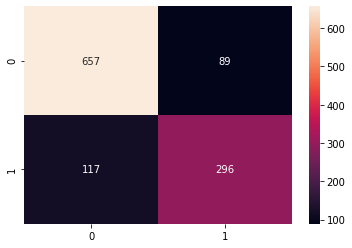

In [52]:
cf_matrix = confusion_matrix(y_test,y_pred_test_xgb_best)
sns.heatmap(cf_matrix, annot=True,fmt="d")

- Terdapat 296 orang yang teprediksi resign dan benar atau True Positive (TP), dan 89 orang teprediksi resign tetapi sebenarnya tidak atau False Positive (FP).
- Terdapat 657 orang yang terprediksi tidak resign dan benar atau True Negative (TN), dan 117 orang yang terprediksi resign tetapi sebenarnya tidak (FN).

# Model Inference

Membagi data inference menjadi X(feature) dan y(target)

In [53]:
# Splitting Dataset

# X will be consist of input parameter only
X_inf = data_inf.drop(['LeaveOrNot'], axis=1)

# y will be consist of target parameter only
y_inf = data_inf['LeaveOrNot']

Melakukan predict Best Model dengan data inference

In [54]:
y_pred_inf_xgb = grid_search_xgb.best_estimator_.predict(X_inf)

Merubah data hasil prediksi menjadi DataFrame

In [55]:
y_pred_inf_df = pd.DataFrame(y_pred_inf_xgb, columns=['XGBoost Prediction'])
y_pred_inf_df

,XGBoost Prediction
0,0
1,0
2,1
3,0
4,0
5,1
6,0
7,1
8,0
9,0


Mengggabungkan Dataframe hasil prediksi dengan data inference

In [56]:
pd.concat([data_inf, y_pred_inf_df], axis=1)

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot,XGBoost Prediction
0,PHD,2013,New Delhi,3,27,Female,No,5,1,0
1,Bachelors,2014,Pune,2,26,Male,No,4,0,0
2,Bachelors,2017,Pune,2,38,Female,No,0,0,1
3,Bachelors,2017,Bangalore,3,33,Female,No,4,1,0
4,Bachelors,2016,Pune,3,25,Male,No,3,0,0
5,Masters,2018,Pune,3,26,Male,No,4,1,1
6,PHD,2013,Pune,3,35,Male,No,0,0,0
7,Masters,2014,New Delhi,3,26,Male,No,4,0,1
8,Masters,2014,Pune,3,38,Male,Yes,2,0,0
9,Masters,2017,New Delhi,2,41,Male,No,3,1,0


- Data inference berhasil diprediksi, untuk hasilnya dapat dilhat pada tabel di atas pada kolom Ada Boost Prediction 

In [64]:
print('ROC AUC Score Test Results XGBoost')
print(accuracy_score(y_inf, y_pred_inf_xgb)) 

ROC AUC Score Test Results XGBoost
0.7


<AxesSubplot:>

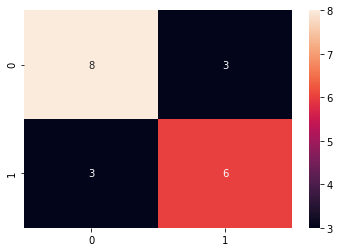

In [58]:
cf_matrix = confusion_matrix(y_inf,y_pred_inf_xgb)
sns.heatmap(cf_matrix, annot=True,fmt="d")

# Saving Model

In [59]:
final_pipeline = make_pipeline(grid_search_xgb.best_estimator_)

In [60]:
with open('model_final.pkl', 'wb') as model:
    pickle.dump(final_pipeline, model)

# Kesimpulan

`EDA`
- Dilihat dari grafik persentase gender, terlihat wanita lebih dominan dengan 57.9%  sedangkan pria hanya 40.3% dari data.
- 34.4% dari data adalah karyawan yang diprediksi akan resign sebesar 34.4% dan yang akan bertahan di perushaan sebesar 65.6%
- 74.2% karyawan pria diprediksi akan bertahan di perusahaan dan 25.8% akan berhenti, sedangkan 52.9% karyawan wanita akan bertahan di perusahaan dan sebesar 47.1% karyawan wanita akan berhenti dari perusahaan. dari data tersebut dapat dilihat persentase wanita yang akan berhenti lebih tinggi dari pria. Terdapat beberapa kemungkinan kenapa persentase wanita lebih banyak resign daripada pria, salah satunya mungkin setelah menikah dan punya anak wanita cenderung akan resign karena ingin fokus mengurus anak dan menjadi ibu rumah tangga.
- Berdasarkan Grafik Persentase Tingkat Pendidikan, Bachelor atau Sarjana menjadi tingkat pendidikan paling tinggi yang terdapat pada data dengan 77.4% diikuti dengan Master dengan 18.8% dan paling kecil PhD atau Doktor dengan 3.8%.
- Pada tingkat pendidikan Sarjana, sebesar 31.4% karyawan akan berhenti dari perusahaan dan 68.6% akan tetap bekerja di perusahaan, pada tingkatan Master 51.2% karyawan memilih tetap bekerja dan 48.8% memilih berhenti dan pada tingkat pendidikan Doktor, sebesar 74.9% memilih tetap bekerja dan 25.1% akan resign. Berdasarkan data tersebut dapat dilihat persentase karyawan yang resign dengan tingkat pendidikan Master lebih tinggi dari tingkat pendidikan lainnya.
- Bersarkan Grafik Persentase Tingkat Pengalaman, dapat dilihat karyawan dengan pengalaman 2 tahun menjadi yang tertinggi dari yang lainnya dengan 23.4%, diikuti dengan pengalaman 4 tahun dengan 20% dan yang terkecil adalah pengalaman 6 dan 7 tahun dengan 0.2%.
- Persentase orang yang resign terlihat seimbang antar variable, tetapi pada tingkat pengalaman 3 tahun terlihat selisih persentase karyawan yang resign dan tidaknya lebih sedikit dibanding tingkat pengalaman lainnya. Dan sangat sedikit karyawan yang bertahan hingga tahun ke 6 dan 7 di perusahaan.
- Pada grafik Education Vs Payment Tier dapat dilihat tingkat pendidikan tidak terlalu berpengaruh terhadap gaji, dimana banyak karyawan yang hanya bergelar sarjana tetap memiliki gaji tinggi.
- Pada grafik Experience vs Payment dapat dilihat karyawan dengan tingkat pengalaman 2 tahun mendapat gaji tinggi lebih banyak dari tingkat pengalaman lainnya, tetapi tingkat pengalaman kerja di suatu domain tidak berpengaruh signifikan terhadap gaji yang didapat.
- Berdsarikan Grafik Persentase Tahun Bergabung, terlihat bahwa banyak karyawan yang bergabung pada tahun 2017 dengan persentase 23.8% dan diikuti dengan tahun 2015 dengan 16.8%, dan yang terendah ada pada tahun 2018 dengan 7.9%.
- Tahun 2018 juga menjadi tahun dengan selisih persentase karyawan resign tertinggi dibandingkan dengan tahun lainnya, dimana persentase karyawan resign mencapai >90% dibandingkan dengan karyawan yang bertahan di perusahaan.
- Berdasarkan Grafik Persentase Karyawan Keluar dari Project, sebesar 87.7% karyawan tidak pernah keluar dari project yang dikerjakan, dan sebanyak 10.3% pernah meninggalkan project yang dikerjakan. Dari 10.3% itu sebanyak 54.6% karyawan bertahan kerja di perusahaan dan 45.4% lainnya resign dari perusahaan. Pernah atau tidaknya seorang karyawan keluar dari sebuah project berpengaruh terhadap karyawan tersebut akan resign atau tidak dari perusahaan, dimana persentase karyawan yang tidak pernah keluar dari project dan resign dari perusahaan lebih kecil dibandingkan dengan karyawan yang pernah meniggalkan project perusahaan.
- Bedasarkan Grafik Persentase Tingkat Gaji, dapat dilihat karyawan dengan gaji tingkat 3 (tinggi) lebih banyak dari tingkatan lainnya dengan persentase 75% dari data, tingkat 2(sedang) sebesar 19.7 dan tingkat 1 (rendah) sebesar 5.2%.
- Karyawan dengan gaji tingkat 3 cenderung bertahan di perusahaan. Dan persentase karyawan tier 2 yang resign dari perusahaan lebig tinggi daripada yang bertahan di perusahaan. Ada indikasi karyawan dengan gaji tingkat 2 yang resign tidak puas dengan gaji yang didapatnya di perusahaan dan mencoba mencari perusahaan lain yang menawarkan gaji yang lebih tinggi.
- Bersarkan grafik heatmap, Payment Tier memiliki korelasi yang tinggi dengan label LeaveOrNot, dengan nilai korelasi sebesar -0.2 den label LeaveOrNot memiliki korelasi paling rendah dengan kolom ExperienceInCurrentDomain dengan poin korelasi sebesar -0.031.
- Kolom 'Age' merupakan skewed distribution data, dan kolom ExperienceInCurrentDomain normal distribution data.
- Tidak terdapat outlier dan mising value pada data

`Modeling`
- Melakukan modeling menggunakan algoritma Logistic Regression dan SVM Classification, Random Forest, Ada Boost, dan XGBoost model dibungkus dengan pipeline
- Ditinjau berdasarkan score ROC-AUC nya model random forest menjadi model dengan nilai roc-auc paling tinggi dibandingkan model lainnya, dengan nilai roc-auc pada train set sebesar 0.92 dan test set sebesar 0.78, perbedaan nilai tersebut diakibatkan karena pada train set dilakukan smote, setelah dilakukan smote data kelas 0 dan 1 nya seimbang sehingga membuat nilai roc-aucnya tinggi.
- Nilai ROC XGBoost menjadi yang tertinggi di test set dibandingkan dengan model lainnya dengan nilai 0.8, dan model logistic menjadi yang terendah nilai roc-auc pada test set dengan 0.72.
- Melakukan Cross Validation pada semua model untuk melihat model mana yang paling baik dalam memprediksi model, CV dilakukan sebanyak 5 kali dengan roc-auc sebagai metric penilaiannya
- Setelah dilakukan cross validation, model XGBoost menadapatkan nilai rata-rata tertinggi dibandingkan model lainnya, dengan nilai 0.9227 +- 0.0267 untuk batas atas dan bawahnya, diikuti dengan model random forest dengan mean score 0.9176 +- 0.0307 untuk batas atas dan bawahnya.
- Setelah dilakukan hyperparameter tuning, didapatkan hyperparameter terbaik untuk random forest,'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_features': 8, 'randomforestclassifier__min_samples_split': 8, 'randomforestclassifier__n_estimators': 200, 
dengan parameter tersebut mendapatkan rata-rata nilai roc-auc sebesar 0.924376
- Setelah dilakukan hyperparameter tuning, selisih antara nilai train dan test sudah berkurang, dan terdapat kenaikan nilai roc-auc sebesar 0.01 atau 1% pada test set setelah dilakukan hyperparameter tuning
- Setelah dilakukan hyperparameter tuning, didapatkan hyperparameter terbaik untuk XGBoost adalah, 'xgbclassifier__booster': 'gbtree', 'xgbclassifier__max_depth': 10, 'xgbclassifier__n_estimators': 30, 'xgbclassifier__tree_method': 'exact', dengan parameter tersebut mendapatkan rata-rata nilai roc-auc sebesar 0.922462
- Terdapat sedikit perbedaan setelah dilakukan hyperparameter tuning, dimana pada train set terjadi sedikit peningkatan dan test set sedikit penurunan score roc-auc
- Berdasarkan nilai roc-auc dan recall, terlihat model xgb sedikit lebih unggul dari model random forest, jadi model XGBOost setelah dilakukan hyperparameter tuning dipilih untuk menjadi model final
- Bersarkan Clasification report, model xgb mendapatkan nilai yang baik pada recallnya, dengan nilai 0.88 pada kelas 0 dan 0.72 pada kelas 1, terdapat perbedaan nilai yang tinggi karena perbedaan data imbalance pada test set.
- Terdapat 296 orang yang teprediksi resign dan benar atau True Positive (TP), dan 89 orang teprediksi resign tetapi sebenarnya tidak atau False Positive (FP).
- Terdapat 657 orang yang terprediksi tidak resign dan benar atau True Negative (TN), dan 117 orang yang terprediksi resign tetapi sebenarnya tidak (FN).